In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from matminer.featurizers.base import MultipleFeaturizer, StackedFeaturizer
from matminer.featurizers import composition as cf
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import GridSearchCV, ShuffleSplit, LeaveOneGroupOut, cross_val_score, learning_curve, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer, LabelEncoder
from sklearn.metrics import roc_curve, auc, r2_score, make_scorer, mean_absolute_error
from sklearn.feature_selection import RFECV
from sklearn import metrics
from pymatgen import Composition
import pickle as pkl
import pandas as pd
import numpy as np
import gzip
import os
import re

In [2]:
saveFigures=False

In [3]:
def featCleanImpute(Y):
    ''' Convert inf to NaN in feature array, in place
    
    Args: 
        Y, feature array, list of ndarray (#samples x #features)
    Returns:
        None
    '''
    # Clean inf values
    for i in range(len(Y)):
        for j in range(len(Y[i])):
            if Y[i][j] == np.inf:
                Y[i][j] = np.nan
            else:
                Y[i][j] = Y[i][j]
                
    # Impute nan values
    imp = Imputer(missing_values='NaN', axis=0, strategy='mean', copy=False)
    imp2 = Imputer(missing_values='NaN', axis=1, strategy='mean', copy=False)

    imp.fit(Y)
    imp.transform(Y)
    imp2.fit(Y)
    imp.transform(Y)
    

# Build Model: Density

Import feature set, import data

In [4]:
with gzip.open('./datasets/density_features.pkl.gz', 'rb') as fp:
    X_dens = pkl.load(fp)
with gzip.open('./datasets/density_data.pkl.gz', 'rb') as fd:
    densityData = pkl.load(fd)

In [5]:
density_model = Pipeline([('impute',Imputer()), 
                          ('model', RandomForestRegressor(n_estimators=100, n_jobs=1, max_features=12))])
dens_featurizer = MultipleFeaturizer([cf.Stoichiometry(), cf.ElementProperty.from_preset("magpie"),
                                 cf.ValenceOrbital(props=['avg']), cf.IonProperty(fast=True),
                                cf.YangSolidSolution(), cf.AtomicPackingEfficiency()])

In [6]:
%%time
density_model.fit(X_dens, y=densityData['density'])

Wall time: 374 ms


Pipeline(memory=None,
     steps=[('impute', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('model', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=12, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False))])

In [7]:
print(np.shape(X_dens))
print(len(density_model.steps[1][1].feature_importances_))
print(len(dens_featurizer.feature_labels()))

(701, 152)
152
152


In [8]:
# Look at feature importances when trained on the whole data set
featureImp = pd.DataFrame(density_model.steps[1][1].feature_importances_,
                          index=dens_featurizer.feature_labels(),
                          columns=['importance']).sort_values('importance',ascending=False)
# featureImp.to_csv(os.path.join(os.getcwd(),'results','defaultDensityModel_features.csv'))

In [9]:
# Look at feature importances when trained on the whole data set
featureImpUnsort = pd.DataFrame(density_model.steps[1][1].feature_importances_,
                          index=dens_featurizer.feature_labels(),
                          columns=['importance'])
featureImpUnsort.iloc[-7]

importance    0.000937
Name: Yang omega, dtype: float64

In [10]:
# make scorer for r2 metric
r2_scorer = make_scorer(r2_score)

In [11]:
np.shape(X_dens)

(701, 152)

In [12]:
# Look at feature correlations..
X_densDF = pd.DataFrame(X_dens, columns=dens_featurizer.feature_labels())
correlations = X_densDF.corr()  # Returns NaN if values do not vary at all...

In [13]:
# find columns that do not vary
invariants =[ i for i in range(152) if correlations.iloc[:, i].isnull().all() ]
print(invariants)
print(X_densDF.columns[invariants])

[55, 60, 72, 84, 90, 102, 120, 125, 142]
Index(['maximum NsValence', 'minimum NpValence', 'minimum NfValence',
       'minimum NsUnfilled', 'minimum NpUnfilled', 'minimum NfUnfilled',
       'minimum GSbandgap', 'mode GSbandgap', 'compound possible'],
      dtype='object')


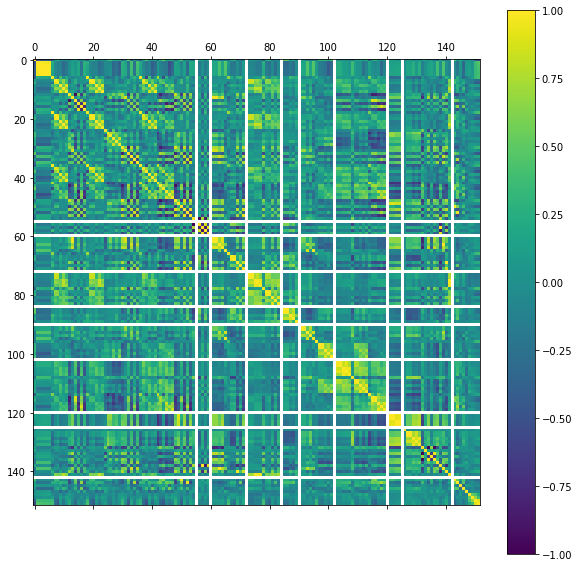

In [14]:
fig, ax = plt.subplots(figsize=(10,10))
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)

In [15]:
np.shape(densityData)

(701, 2)

In [65]:
%%time
# Try recursive feature elimination
RF = RandomForestRegressor(n_estimators=100, n_jobs=1)

rfecv = RFECV(estimator=RF, step=2, cv=KFold(5),
              scoring=r2_scorer)
if False: # Takes forever
    rfecv.fit(X_dens, densityData['density']) 

RFECV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
   estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
   n_jobs=1, scoring=make_scorer(r2_score), step=1, verbose=0)

Optimal number of features : 16


(0.75, 0.85)

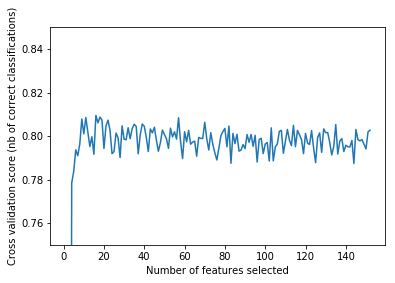

In [69]:
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.ylim([0.75, 0.85])

# Generate learning curves, assess quality of model

In [11]:
train_sizes, train_scores, valid_scores = learning_curve(density_model, X_dens, densityData['density'], cv=ShuffleSplit(),
                                                          scoring=r2_scorer)

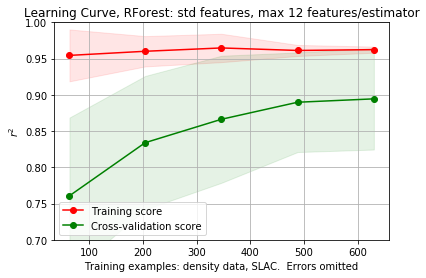

In [12]:
plt.figure()
plt.title('Learning Curve, RForest: std features, max 12 features/estimator')
plt.xlabel("Training examples: density data, SLAC.  Errors omitted")
plt.ylabel("$r^2$")
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(valid_scores, axis=1)
test_scores_std = np.std(valid_scores, axis=1)
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")
plt.ylim([0.7, 1])

if saveFigures:
    plt.savefig(os.path.join(os.getcwd(), 'results', 'baseModel_densityPruned.png'))
    print('figure saved')

In [13]:
#take predicted values from each cross validation set to ensure training not performed on own set.  Take 200 training samples
# Probably could have used cross_val_predict
kf = KFold(5)
rep=0
densityData['density_predict'] = np.nan
for train_index, test_index in kf.split(densityData['comp']):
    print('Split #{}'.format(rep))
    density_model.fit(X_dens[train_index,:], densityData['density'][train_index])
    
    y_densPredict = density_model.predict(X_dens[test_index,:])
    densityData['density_predict'][test_index] = y_densPredict
    
    #print(train_index, test_index)
    rep+=1
#y_densPredict = 

Split #0
Split #1
Split #2
Split #3
Split #4


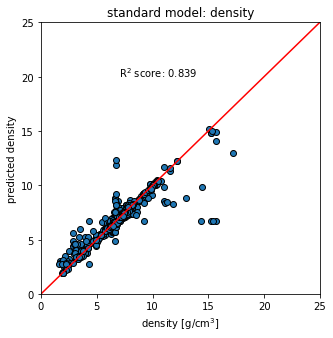

In [14]:
plt.figure(figsize=(5,5))
plt.scatter(densityData['density'], densityData['density_predict'], edgecolors='k')
plt.plot([0,30], [0,30], 'r-')
plt.xlabel('density [g/cm$^3$]')
plt.ylabel('predicted density')

r2Std = r2_score(densityData['density'], densityData['density_predict'])
plt.text(7,20, 'R$^2$ score: {:.3f}'.format(r2Std))
plt.xlim([0,25])
plt.ylim([0,25])
plt.title('standard model: density')

if saveFigures:
    plt.savefig(os.path.join(os.getcwd(),'results','densityScatter.png'))
    print('figure saved')

Compare to Vegard's law, rule of mixtures

In [15]:
elemProp = pd.read_excel('datasets/ElementalDensityIonizationTable.xlsx')
elemDensity = elemProp[['symbol', 'density [g/cm3]']]

def vegardsDensity(comp):
    '''
    input: Composition object
    '''
        
    density=0
    elemSet = set(comp.elements)
    subscriptCnt = 0
    
    for elem in elemSet:
        subscriptCnt += comp[elem]
        try: 
            densityPart = comp[elem]*elemDensity[ elemDensity['symbol'] == str(elem)]['density [g/cm3]'].item()
        except:
            print('element {} not found?'.format(elem))
            return 'error'
            
        density += densityPart
        # print('element {} added density of {}: {}'.format(elem, densityPart, density))
                
    # print(subscriptCnt)
    return density / subscriptCnt

In [16]:
comp = Composition('Ag10Zn30')
comp2 = Composition('Ca3Al4')

In [17]:
densityData['density_vegards'] = np.nan
densityData['density_vegards'] = [vegardsDensity(c) for c in densityData['comp']]

In [18]:
#densityData['density_vegards'] = pd.Series([vegardsDensity(comp) for comp in densityData['comp']])
r2Vegards = r2_score(densityData['density'],densityData['density_vegards'])
r2RF = r2_score(densityData['density'], densityData['density_predict'])
print('Vegards: {}, Random Forest Regressor: {}'.format(r2Vegards, r2RF))

Vegards: 0.8614466511737545, Random Forest Regressor: 0.8389903621264675


In [19]:
#densityData[densityData['density_vegards']=='error']

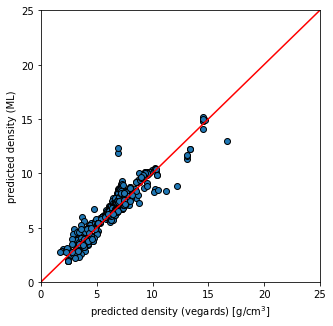

In [20]:
plt.figure(figsize=(5,5))
plt.scatter(densityData['density_vegards'], densityData['density_predict'], edgecolors='k')
plt.plot([0,30], [0,30], 'r-')
plt.xlabel('predicted density (vegards) [g/cm$^3$]')
plt.ylabel('predicted density (ML)')

plt.xlim([0,25])
plt.ylim([0,25])

if saveFigures:
    plt.savefig(os.path.join(os.getcwd(),'results','densityVegards.png'))
    print('figure saved')

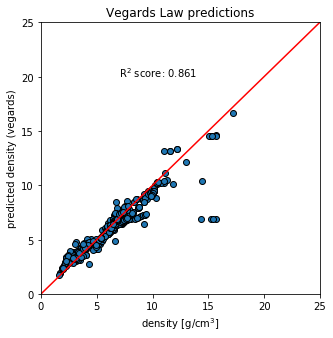

In [21]:
plt.figure(figsize=(5,5))
plt.scatter(densityData['density'], densityData['density_vegards'], edgecolors='k')
plt.plot([0,30], [0,30], 'r-')
plt.xlabel('density [g/cm$^3$]')
plt.ylabel('predicted density (vegards)')
plt.title('Vegards Law predictions')

r2V = r2_score(densityData['density'], densityData['density_vegards'])
plt.text(7,20, 'R$^2$ score: {:.3f}'.format(r2V))

plt.xlim([0,25])
plt.ylim([0,25])

if saveFigures:
    plt.savefig(os.path.join(os.getcwd(),'results','densityVegardsVsTruth.png'))
    print('figure saved')

# Alternate Feature Set, only mean from ElementProperty feature set

In [22]:
densModel_meanOnly = Pipeline([('impute',Imputer()), 
                          ('model', RandomForestRegressor(n_estimators=100, n_jobs=1, max_features=12))])
elemPropFeatures = ["Number", "MendeleevNumber", "AtomicWeight", "MeltingT",
                        "Column", "Row", "CovalentRadius",
                        "Electronegativity", "NsValence", "NpValence",
                        "NdValence", "NfValence", "NValence",
                        "NsUnfilled", "NpUnfilled", "NdUnfilled", "NfUnfilled",
                        "NUnfilled", "GSvolume_pa",
                        "GSbandgap", "GSmagmom", "SpaceGroupNumber"]

densMean_featurizer = MultipleFeaturizer([cf.Stoichiometry(), 
                          cf.ElementProperty(data_source='magpie', features = elemPropFeatures,
                                                    stats=['mean']),
                                 cf.ValenceOrbital(props=['avg']), cf.IonProperty(fast=True),
                                cf.YangSolidSolution(), cf.AtomicPackingEfficiency()])

In [23]:
%%time
if False: # don't auto run while re-initializing
    X_meanDens = densMean_featurizer.featurize_many(densityData['comp'], ignore_errors=True)
    X_meanDens = np.array(X_meanDens)
    X_meanDens.astype(float)
    print('Computed {} features'.format(X_meanDens.shape[1]))
    
    with gzip.open('./datasets/densMean_features.pkl.gz', 'wb') as fp:
    pkl.dump(X_meanDens, fp)


Computed 42 features
Wall time: 16min 56s


In [25]:
with gzip.open('./datasets/densMean_features.pkl.gz', 'rb') as fp:
    X_meanDens = pkl.load(fp)

In [26]:
%%time 
# Fit the model
densModel_meanOnly.fit(X_meanDens, densityData['density'])

Wall time: 437 ms


Pipeline(memory=None,
     steps=[('impute', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('model', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=12, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False))])

In [27]:
#take predicted values from each cross validation set to ensure training not performed on own set.  Take 200 training samples
# Probably could have used cross_val_predict
kf = KFold(5)
rep=0
densityData['density_predict_meanOnly'] = np.nan
for train_index, test_index in kf.split(densityData['comp']):
    print('Split #{}'.format(rep))
    density_model.fit(X_meanDens[train_index,:], densityData['density'][train_index])
    
    y_densPredict = density_model.predict(X_meanDens[test_index,:])
    densityData['density_predict_meanOnly'][test_index] = y_densPredict
    
    #print(train_index, test_index)
    rep+=1
#y_densPredict = 

Split #0
Split #1
Split #2
Split #3
Split #4


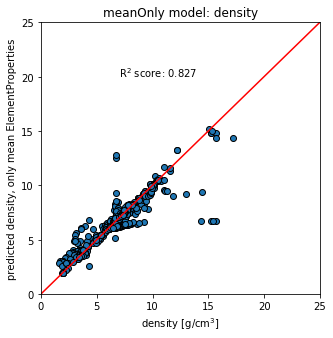

In [28]:
# plot Comparison, report r2
r2meanOnly = r2_score(densityData['density'], densityData['density_predict_meanOnly'])

plt.figure(figsize=(5,5))
plt.scatter(densityData['density'], densityData['density_predict_meanOnly'], edgecolors='k')
plt.plot([0,30], [0,30], 'r-')
plt.xlabel('density [g/cm$^3$]')
plt.ylabel('predicted density, only mean ElementProperties')


plt.text(7,20, 'R$^2$ score: {:.3f}'.format(r2meanOnly))
plt.xlim([0,25])
plt.ylim([0,25])
plt.title('meanOnly model: density')

if saveFigures:
    plt.savefig(os.path.join(os.getcwd(),'results','densityScatter_meanOnly.png'))
    print('figure saved')

In [29]:
train_sizesMean, train_scoresMean, valid_scoresMean = learning_curve(densModel_meanOnly, X_meanDens, densityData['density'], cv=ShuffleSplit(),
                                                          scoring=r2_scorer)

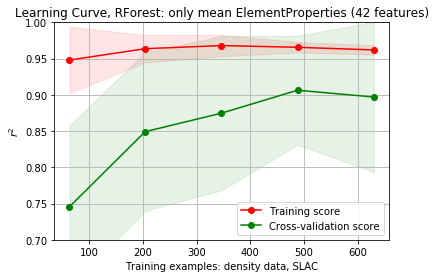

In [30]:
plt.figure()
plt.title('Learning Curve, RForest: only mean ElementProperties (42 features)')
plt.xlabel("Training examples: density data, SLAC")
plt.ylabel("$r^2$")
train_scores_mean = np.mean(train_scoresMean, axis=1)
train_scores_std = np.std(train_scoresMean, axis=1)
test_scores_mean = np.mean(valid_scoresMean, axis=1)
test_scores_std = np.std(valid_scoresMean, axis=1)
plt.grid()

plt.fill_between(train_sizesMean, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizesMean, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizesMean, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizesMean, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")
plt.ylim([0.7, 1])

if saveFigures:
    plt.savefig(os.path.join(os.getcwd(), 'results', 'baseModel_densityMeanOnly.png'))

# Investigating poorly performing predictions

In [31]:
largeErrorDensity = densityData[ [ abs((x-y)/x) > 0.5 for x,y in zip(densityData['density'], densityData['density_predict']) ]]

In [32]:
largeErrorDensity

,comp,density,density_predict,density_vegards,density_predict_meanOnly
1,"(Al, Fe, B)",3.539,5.961703,3.66200,4.867570
4,"(Hf, Al, Ni)",2.835,5.590662,3.85050,4.072068
5,"(Nb, Al, Ni)",3.449,5.207348,3.61350,4.091582
24,"(Al, V, Fe)",2.884,4.858210,2.93980,3.824512
25,"(Ti, Al, Fe)",2.87,4.432590,2.89540,3.816362
56,"(Y, Mg, Zn, Cu)",2.47,3.963002,2.80927,3.737472
67,"(Ca, Al)",1.738,3.074890,1.93640,3.020243
68,"(Ca, Al, Ag)",2.197,3.504819,2.79000,3.286815
69,"(Ca, Mg, Al)",1.736,2.836240,1.91400,2.850255
70,"(Ca, Al, Zn)",2,3.038433,2.45300,3.078585


In [33]:
for comp in largeErrorDensity['comp']:
    print(comp)

Al3 Fe1 B1
Hf1 Al17 Ni2
Nb1 Al17 Ni2
Al47 V2 Fe1
Ti5 Al93 Fe2
Y4.7 Mg81 Zn5 Cu9.3
Ca66.4 Al33.6
Ca6 Al3 Ag1
Ca6 Mg1 Al3
Ca6 Al3 Zn1
Ca56.5 Mg10 Al28.5 Cu5
Ca56.5 Mg10 Al28.5 Ag5
Ca14 Mg3 Al3
Zr57 Nb5 Al10 Cu15.4 Ni12.6
Sr30 Mg9 Zn11
Sr12 Li1 Mg3 Zn4
Sr12 Mg4 Zn3 Cu1
Ca31 Yb18 Mg11 Zn40
Zr57 Nb5 Al10 Cu15.4 Ni12.6
Zr57 Nb5 Al10 Cu15.4 Ni12.6
Zr57 Nb5 Al10 Cu15.4 Ni12.6
Zr57 Nb5 Al10 Cu15.4 Ni12.6
Zr57 Nb5 Al10 Cu15.4 Ni12.6


# Try removing density-related features

In [34]:
densModel_noVol = Pipeline([('impute',Imputer()), 
                          ('model', RandomForestRegressor(n_estimators=100, n_jobs=1, max_features=12))])
elemPropFeatures2 = ["Number", "MendeleevNumber", "AtomicWeight", "MeltingT",
                        "Column", "Row", #"CovalentRadius",
                        "Electronegativity", "NsValence", "NpValence",
                        "NdValence", "NfValence", "NValence",
                        "NsUnfilled", "NpUnfilled", "NdUnfilled", "NfUnfilled",
                        "NUnfilled", #"GSvolume_pa",
                        "GSbandgap", "GSmagmom", "SpaceGroupNumber"]

densMean_feat_noVol = MultipleFeaturizer([cf.Stoichiometry(), 
                          cf.ElementProperty(data_source='magpie', features = elemPropFeatures2,
                                                    stats=['mean']),
                                 cf.ValenceOrbital(props=['avg']), cf.IonProperty(fast=True),
                                cf.YangSolidSolution(), cf.AtomicPackingEfficiency()])

In [35]:
%%time
if False:
    X_noVolDens = densMean_feat_noVol.featurize_many(densityData['comp'], ignore_errors=True)
    X_noVolDens = np.array(X_noVolDens)
    X_noVolDens.astype(float)
    print('Computed {} features'.format(X_noVolDens.shape[1]))
    
    with gzip.open('./datasets/densNoVol_features.pkl.gz', 'wb') as fp:
    pkl.dump(X_noVolDens, fp)


Computed 40 features
Wall time: 17min 15s


In [ ]:
with gzip.open('./datasets/densNoVol_features.pkl.gz', 'rb') as fp:
    X_noVolDens = pkl.load(fp)

In [80]:
%%time 
# Fit the model
densModel_noVol.fit(X_noVolDens, densityData['density'])

Wall time: 452 ms


Pipeline(memory=None,
     steps=[('impute', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('model', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=12, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False))])

In [81]:
#take predicted values from each cross validation set to ensure training not performed on own set.  Take 200 training samples
# Probably could have used cross_val_predict
kf = KFold(5)
rep=0
densityData['density_predict_meanNoVol'] = np.nan
for train_index, test_index in kf.split(densityData['comp']):
    print('Split #{}'.format(rep))
    densModel_noVol.fit(X_noVolDens[train_index,:], densityData['density'][train_index])
    
    y_densPredict = densModel_noVol.predict(X_noVolDens[test_index,:])
    densityData['density_predict_meanNoVol'][test_index] = y_densPredict
    
    
    featureImp = pd.DataFrame(densModel_noVol.steps[1][1].feature_importances_,
                          index=densMean_feat_noVol.feature_labels(),
                          columns=['importance']).sort_values('importance',ascending=False)
    print(featureImp.head())
    
    
    #print(train_index, test_index)
    rep+=1
#y_densPredict = 

Split #0
                        importance
mean NValence             0.152423
mean Electronegativity    0.105795
mean Column               0.088238
mean NUnfilled            0.082573
mean NdValence            0.059823
Split #1
                        importance
mean NValence             0.182039
mean MeltingT             0.123288
mean Number               0.117519
mean Electronegativity    0.087840
mean AtomicWeight         0.086393
Split #2
                         importance
mean MeltingT              0.139149
mean NValence              0.130277
mean NdValence             0.105772
mean Number                0.096380
avg d valence electrons    0.081973
Split #3
                        importance
mean NValence             0.170359
mean AtomicWeight         0.143176
mean Number               0.121652
mean MeltingT             0.080153
mean Electronegativity    0.062045
Split #4
                        importance
mean NValence             0.235889
mean MeltingT             0.116547
mean

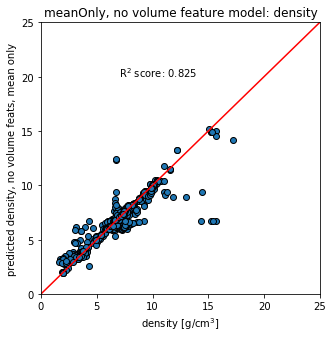

In [82]:
# plot Comparison, report r2
r2meanNoVol = r2_score(densityData['density'], densityData['density_predict_meanNoVol'])

plt.figure(figsize=(5,5))
plt.scatter(densityData['density'], densityData['density_predict_meanNoVol'], edgecolors='k')
plt.plot([0,30], [0,30], 'r-')
plt.xlabel('density [g/cm$^3$]')
plt.ylabel('predicted density, no volume feats, mean only')


plt.text(7,20, 'R$^2$ score: {:.3f}'.format(r2meanNoVol))
plt.xlim([0,25])
plt.ylim([0,25])
plt.title('meanOnly, no volume feature model: density')

plt.savefig(os.path.join(os.getcwd(),'results','densityScatter_meanNoVol.png'))

In [83]:
train_sizesNoVol, train_scoresNoVol, valid_scoresNoVol = learning_curve(densModel_noVol, X_noVolDens, densityData['density'], cv=ShuffleSplit(),
                                                          scoring=r2_scorer)

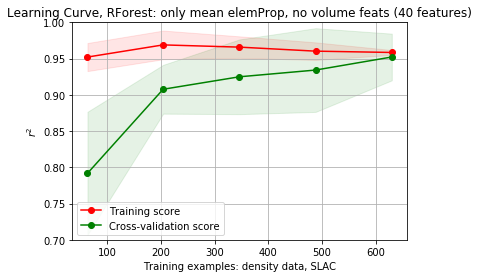

In [84]:
plt.figure()
plt.title('Learning Curve, RForest: only mean elemProp, no volume feats (40 features)')
plt.xlabel("Training examples: density data, SLAC")
plt.ylabel("$r^2$")
train_scores_mean = np.mean(train_scoresNoVol, axis=1)
train_scores_std = np.std(train_scoresNoVol, axis=1)
test_scores_mean = np.mean(valid_scoresNoVol, axis=1)
test_scores_std = np.std(valid_scoresNoVol, axis=1)
plt.grid()

plt.fill_between(train_sizesNoVol, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizesNoVol, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizesNoVol, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizesNoVol, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")
plt.ylim([0.7, 1])

plt.savefig(os.path.join(os.getcwd(), 'results', 'baseModel_densityMeanNoVol.png'))

# Train model on difference from Vegards Predictions

In [85]:
densityData['vegards_diff'] = densityData['density'] - densityData['density_vegards']

In [86]:
print('mean difference: {:.3f}, variance {:.3f}'.format(densityData['vegards_diff'].mean(), densityData['vegards_diff'].var()))
print('max difference: {:.3f}, min difference {:.3f}'.format(densityData['vegards_diff'].max(), densityData['vegards_diff'].min()))

mean difference: 0.161, variance 0.707
max difference: 8.760, min difference -2.111


In [87]:
densDiffModel = Pipeline([('impute',Imputer()), 
                          ('model', RandomForestRegressor(n_estimators=100, n_jobs=1, max_features=12))])

In [88]:
%%time
densDiffModel.fit(X_dens, densityData['vegards_diff'])

Wall time: 374 ms


Pipeline(memory=None,
     steps=[('impute', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('model', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=12, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False))])

In [89]:
# Look at feature importances when trained on the whole data set
featureImp = pd.DataFrame(densDiffModel.steps[1][1].feature_importances_,
                          index=dens_featurizer.feature_labels(),
                          columns=['importance']).sort_values('importance',ascending=False)
featureImp.head()
# featureImp.to_csv(os.path.join(os.getcwd(),'results','defaultDensityModel_features.csv'))

,importance
avg ionic char,0.035268
mean MeltingT,0.029611
avg_dev NValence,0.026608
mean Electronegativity,0.023390
avg_dev Column,0.023176


In [90]:
#take predicted values from each cross validation set to ensure training not performed on own set.  Take 200 training samples
# Probably could have used cross_val_predict

compTrouble = Composition('Zr57 Nb5 Al10 Cu15.4 Ni12.6')
# Also probe interesting composition

kf = KFold(5)
rep=0
densityData['diff_predict'] = np.nan
for train_index, test_index in kf.split(densityData['comp']):
    print('Split #{}'.format(rep))
    densDiffModel.fit(X_dens[train_index,:], densityData['vegards_diff'][train_index])
    
    y_densPredict = densDiffModel.predict(X_dens[test_index,:])
    densityData['diff_predict'][test_index] = y_densPredict
    
    troublePred = densDiffModel.predict(X_dens[615,:].reshape(1,-1))
    
    print('prediction for trouble comp: {}'.format(troublePred))
    
    #print(train_index, test_index)
    rep+=1
#y_densPredict = 

Split #0
prediction for trouble comp: [4.5519425]
Split #1
prediction for trouble comp: [5.20709701]
Split #2
prediction for trouble comp: [4.46903033]
Split #3
prediction for trouble comp: [5.27161027]
Split #4
prediction for trouble comp: [-0.1883346]


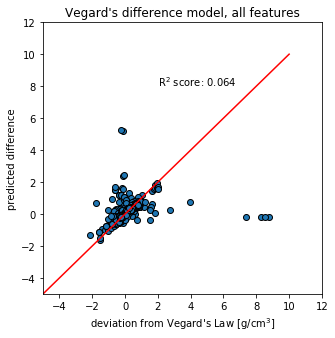

In [91]:
plt.figure(figsize=(5,5))
plt.scatter(densityData['vegards_diff'], densityData['diff_predict'], edgecolors='k')
plt.plot([-10, 10], [-10, 10], 'r-')
plt.xlabel("deviation from Vegard's Law [g/cm$^3$]")
plt.ylabel('predicted difference')
plt.title("Vegard's difference model, all features")

r2V = r2_score(densityData['vegards_diff'], densityData['diff_predict'])
plt.text(2,8, 'R$^2$ score: {:.3f}'.format(r2V))

plt.xlim([-5,12])
plt.ylim([-5,12])

plt.savefig(os.path.join(os.getcwd(),'results','diffScatter_allFeats.png'))

In [92]:
densityData[ abs(densityData['vegards_diff']) > 5]

,comp,density,density_predict,density_vegards,density_predict_meanOnly,density_predict_meanNoVol,vegards_diff,diff_predict
606,"(Zr, Nb, Al, Cu, Ni)",15.2,6.722799,6.91044,6.720879,6.721702,8.28956,-0.188335
607,"(Zr, Nb, Al, Cu, Ni)",14.3,6.722799,6.91044,6.720879,6.721702,7.38956,-0.188335
608,"(Zr, Nb, Al, Cu, Ni)",15.67,6.722799,6.91044,6.720879,6.721702,8.75956,-0.188335
609,"(Zr, Nb, Al, Cu, Ni)",15.44,6.722799,6.91044,6.720879,6.721702,8.52956,-0.188335


In [93]:
compTrouble = Composition('Zr57 Nb5 Al10 Cu15.4 Ni12.6')
densityData[ [compTrouble.almost_equals(c) for c in densityData['comp']] ]

,comp,density,density_predict,density_vegards,density_predict_meanOnly,density_predict_meanNoVol,vegards_diff,diff_predict
155,"(Zr, Nb, Al, Cu, Ni)",6.758,11.899989,6.91044,12.484196,12.307016,-0.15244,5.207097
458,"(Zr, Nb, Al, Cu, Ni)",6.69,12.325799,6.91044,12.761966,12.440986,-0.22044,5.271610
606,"(Zr, Nb, Al, Cu, Ni)",15.2,6.722799,6.91044,6.720879,6.721702,8.28956,-0.188335
607,"(Zr, Nb, Al, Cu, Ni)",14.3,6.722799,6.91044,6.720879,6.721702,7.38956,-0.188335
608,"(Zr, Nb, Al, Cu, Ni)",15.67,6.722799,6.91044,6.720879,6.721702,8.75956,-0.188335
609,"(Zr, Nb, Al, Cu, Ni)",15.44,6.722799,6.91044,6.720879,6.721702,8.52956,-0.188335
615,"(Zr, Nb, Al, Cu, Ni)",6.68,6.722799,6.91044,6.720879,6.721702,-0.23044,-0.188335


In [94]:
x_trouble = dens_featurizer.featurize(compTrouble)
np.shape(x_trouble)

(152,)

In [95]:
densDiffModel.predict(X_dens[615,:].reshape(1,-1))

array([-0.1883346])

...Why does this happen?  For the same composition one should get the same features, yet the predicted density varies.  This is also true for the previous predictions.  

Should probably depend on the specific split used to train the model

In [96]:
compTrouble.almost_equals(densityData.loc[606]['comp'])

True

In [97]:
densityData.head()

,comp,density,density_predict,density_vegards,density_predict_meanOnly,density_predict_meanNoVol,vegards_diff,diff_predict
0,"(Ce, Al)",3.462,3.967243,3.1070,3.811169,3.761203,0.355,0.307466
1,"(Al, Fe, B)",3.539,5.961703,3.6620,4.867570,4.972765,-0.123,0.558711
2,"(Zr, Al, Ni)",3.384,4.085152,3.5105,4.019465,3.682056,-0.1265,0.156822
3,"(Zr, Al, Ni)",3.517,4.240630,3.6965,4.205598,3.927851,-0.1795,0.129934
4,"(Hf, Al, Ni)",2.835,5.590662,3.8505,4.072068,3.887592,-1.0155,0.279791


In [98]:
#  Examine performance without outliers (trouble compositions)
notTroubleDF = densityData[ [not compTrouble.almost_equals(c) for c in densityData['comp']] ]
notTroubleDF.reset_index(inplace=True, drop=True)
print('Deviation Prediction, r2 sans outliers: {}'.format(r2_score(notTroubleDF['vegards_diff'], notTroubleDF['diff_predict'])))

Deviation Prediction, r2 sans outliers: 0.4843386868661409


In [99]:
#  Examine performance without outliers in normal model
print('Density Prediction, r2 sans outliers: {}'.format(r2_score(notTroubleDF['density_predict'], notTroubleDF['density'])))

Density Prediction, r2 sans outliers: 0.9086074867498517


Make sure is true

See if there's any learning at all 

Everything else must be process dependant, experimental, bad data, etc

In [100]:
X_notTrouble = X_dens[ [not compTrouble.almost_equals(c) for c in densityData['comp']] ]

In [101]:
# how is learning in general without outliers?  Train on whole feature set
densFeatTop = pd.DataFrame()

# take predicted values from each cross validation set to ensure training not performed on own set.  Take 200 training samples
# Probably could have used cross_val_predict
kf = KFold(5)
rep=0
notTroubleDF['density_predict_noOutlier'] = np.nan
for train_index, test_index in kf.split(notTroubleDF['comp']):
    print('Split #{}'.format(rep))
    density_model.fit(X_notTrouble[train_index,:], notTroubleDF['density'][train_index])
    
    y_densPredict = density_model.predict(X_notTrouble[test_index,:])
    notTroubleDF['density_predict_noOutlier'][test_index] = y_densPredict
    
    
    featureImp = pd.DataFrame(density_model.steps[1][1].feature_importances_,
                          index=dens_featurizer.feature_labels(),
                          columns=['importance']).sort_values('importance',ascending=False)
    print(featureImp.head())
    
    densFeatTop = densFeatTop.append(featureImp)

    
    #print(train_index, test_index)
    rep+=1
#y_densPredict = 

Split #0
                        importance
mean Electronegativity    0.065685
mode Number               0.060162
mean NValence             0.052179
mode NValence             0.049069
mode Column               0.037593
Split #1
                   importance
mean NValence        0.067496
mode Number          0.064752
mode AtomicWeight    0.064232
mean MeltingT        0.046130
mean AtomicWeight    0.041483
Split #2
                importance
mode Number       0.066134
mean NdValence    0.055200
mean NValence     0.051233
mode MeltingT     0.048094
mean MeltingT     0.047988
Split #3
                   importance
mean Number          0.073356
mode NValence        0.067999
mode Number          0.060634
mean NValence        0.059200
mode AtomicWeight    0.054610
Split #4
                   importance
mode Number          0.097569
mode AtomicWeight    0.075039
mode NValence        0.063696
mean NValence        0.056127
mean MeltingT        0.039384


In [102]:
densFeatTop['totalImp'] = densFeatTop.groupby(level=0)['importance'].transform('sum')
densFeatTop = densFeatTop.drop_duplicates(subset=['totalImp']).sort_values('totalImp',ascending=False)
print('top features over 5 training splits')
densFeatTop.head()

top features over 5 training splits


,importance,totalImp
mode Number,0.060162,0.349252
mean NValence,0.052179,0.286235
mode AtomicWeight,0.025568,0.260935
mode NValence,0.049069,0.258786
mean Number,0.018204,0.195328


In [103]:
densFeatTop.to_csv(os.path.join(os.getcwd(),'results','avgTopFeats_densityNoOutliers.csv'))

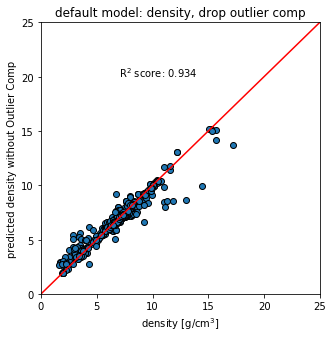

In [104]:
# plot Comparison, report r2
r2noOut = r2_score(notTroubleDF['density'], notTroubleDF['density_predict_noOutlier'])

plt.figure(figsize=(5,5))
plt.scatter(notTroubleDF['density'], notTroubleDF['density_predict_noOutlier'], edgecolors='k')
plt.plot([0,30], [0,30], 'r-')
plt.xlabel('density [g/cm$^3$]')
plt.ylabel('predicted density without Outlier Comp')


plt.text(7,20, 'R$^2$ score: {:.3f}'.format(r2noOut))
plt.xlim([0,25])
plt.ylim([0,25])
plt.title('default model: density, drop outlier comp')

if saveFigures:
    plt.savefig(os.path.join(os.getcwd(),'results','densityScatter_noOutliers_allFeats.png'))
    print('figure saved')

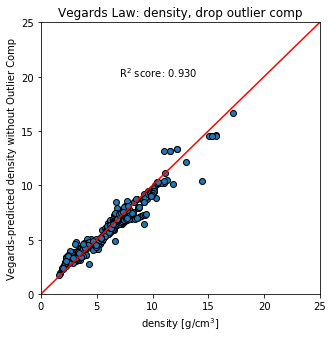

In [105]:
# plot Comparison, report r2
r2noOut = r2_score(notTroubleDF['density'], notTroubleDF['density_vegards'])

plt.figure(figsize=(5,5))
plt.scatter(notTroubleDF['density'], notTroubleDF['density_vegards'], edgecolors='k')
plt.plot([0,30], [0,30], 'r-')
plt.xlabel('density [g/cm$^3$]')
plt.ylabel('Vegards-predicted density without Outlier Comp')


plt.text(7,20, 'R$^2$ score: {:.3f}'.format(r2noOut))
plt.xlim([0,25])
plt.ylim([0,25])
plt.title('Vegards Law: density, drop outlier comp')

if saveFigures:
    plt.savefig(os.path.join(os.getcwd(),'results','densityScatter_noOutliers_vegards.png'))
    print('figure saved')

In [106]:
train_sizesNoOut, train_scoresNoOut, valid_scoresNoOut = learning_curve(density_model, X_notTrouble, notTroubleDF['density'], 
                                                                    cv=ShuffleSplit(), scoring=r2_scorer)

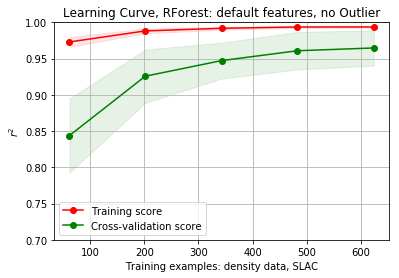

In [107]:
plt.figure()
plt.title('Learning Curve, RForest: default features, no Outlier')
plt.xlabel("Training examples: density data, SLAC")
plt.ylabel("$r^2$")
train_scores_mean = np.mean(train_scoresNoOut, axis=1)
train_scores_std = np.std(train_scoresNoOut, axis=1)
test_scores_mean = np.mean(valid_scoresNoOut, axis=1)
test_scores_std = np.std(valid_scoresNoOut, axis=1)
plt.grid()

plt.fill_between(train_sizesNoOut, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizesNoOut, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizesNoOut, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizesNoOut, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")
plt.ylim([0.7, 1])

if saveFigures:
    plt.savefig(os.path.join(os.getcwd(), 'results', 'learningCurve_noOutlier.png'))
    print('saved figure')

## Train on difference between density and vegards, see what features float up
Not including outliers

In [108]:
notTroubleDF.head()

,comp,density,density_predict,density_vegards,density_predict_meanOnly,density_predict_meanNoVol,vegards_diff,diff_predict,density_predict_noOutlier
0,"(Ce, Al)",3.462,3.967243,3.1070,3.811169,3.761203,0.355,0.307466,4.338898
1,"(Al, Fe, B)",3.539,5.961703,3.6620,4.867570,4.972765,-0.123,0.558711,5.647757
2,"(Zr, Al, Ni)",3.384,4.085152,3.5105,4.019465,3.682056,-0.1265,0.156822,4.401826
3,"(Zr, Al, Ni)",3.517,4.240630,3.6965,4.205598,3.927851,-0.1795,0.129934,4.550935
4,"(Hf, Al, Ni)",2.835,5.590662,3.8505,4.072068,3.887592,-1.0155,0.279791,5.469309


In [109]:
# Train on difference
diffFeatTop5 = pd.DataFrame()

# take predicted values from each cross validation set to ensure training not performed on own set.  Take 200 training samples
# Probably could have used cross_val_predict
kf = KFold(5)
rep=0
notTroubleDF['diff_predict'] = np.nan
for train_index, test_index in kf.split(notTroubleDF['comp']):
    print('Split #{}, training on {}'.format(rep, len(train_index)))
    density_model.fit(X_notTrouble[train_index,:], notTroubleDF['vegards_diff'][train_index])
    
    y_diffPredict = density_model.predict(X_notTrouble[test_index,:])
    notTroubleDF['diff_predict'][test_index] = y_diffPredict
    
    
    featureImp = pd.DataFrame(density_model.steps[1][1].feature_importances_,
                          index=dens_featurizer.feature_labels(),
                          columns=['importance']).sort_values('importance',ascending=False)
    print(featureImp.head())
    
    diffFeatTop5 = diffFeatTop5.append(featureImp)

    
    #print(train_index, test_index)
    rep+=1
#y_densPredict = 

Split #0, training on 555
                        importance
avg_dev GSbandgap         0.044552
mean GSbandgap            0.032233
mean NpValence            0.030110
minimum CovalentRadius    0.027130
mean CovalentRadius       0.026109
Split #1, training on 555
                        importance
minimum CovalentRadius    0.052362
avg_dev GSbandgap         0.038330
minimum GSvolume_pa       0.031254
mean GSbandgap            0.028582
avg_dev NdValence         0.027214
Split #2, training on 555
                        importance
avg_dev Column            0.058895
mean GSmagmom             0.042948
mean Electronegativity    0.037889
avg_dev GSbandgap         0.034547
range GSbandgap           0.029998
Split #3, training on 555
                        importance
avg_dev Column            0.031193
minimum CovalentRadius    0.030716
avg_dev NpValence         0.029232
mean GSbandgap            0.028376
minimum GSvolume_pa       0.025581
Split #4, training on 556
                        import

In [110]:
diffFeatTop5['totalImp'] = diffFeatTop5.groupby(level=0)['importance'].transform('sum')
diffFeatTop = diffFeatTop5.drop_duplicates(subset=['totalImp']).sort_values('totalImp',ascending=False)
print('top features over 5 training splits')
diffFeatTop.head()
diffFeatTop.to_csv(os.path.join(os.getcwd(),'results','avgTopFeats_densityVegardsDiff.csv'))

top features over 5 training splits


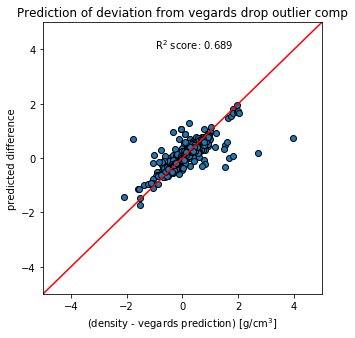

In [111]:
# plot Comparison, report r2
r2noOutDiff = r2_score(notTroubleDF['vegards_diff'], notTroubleDF['diff_predict'])

plt.figure(figsize=(5,5))
plt.scatter(notTroubleDF['vegards_diff'], notTroubleDF['diff_predict'], edgecolors='k')
plt.plot([-5,5], [-5,5], 'r-')
plt.xlabel('(density - vegards prediction) [g/cm$^3$]')
plt.ylabel('predicted difference')


plt.text(-1,4, 'R$^2$ score: {:.3f}'.format(r2noOutDiff))
plt.xlim([-5,5])
plt.ylim([-5,5])
plt.title('Prediction of deviation from vegards drop outlier comp')

if saveFigures:
    plt.savefig(os.path.join(os.getcwd(),'results','densityDiffScatter_noOutliers.png'))
    print('figure saved')

In [112]:
train_sizes, train_scores, valid_scores = learning_curve(density_model, X_notTrouble, notTroubleDF['vegards_diff'], 
                                                                    cv=ShuffleSplit(), scoring=r2_scorer)

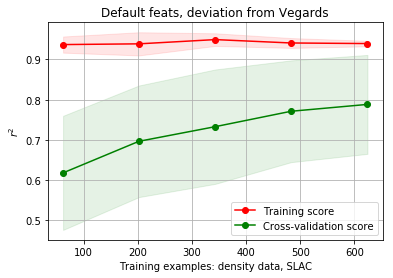

In [113]:
plt.figure()
plt.title('Default feats, deviation from Vegards')
plt.xlabel("Training examples: density data, SLAC")
plt.ylabel("$r^2$")
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(valid_scores, axis=1)
test_scores_std = np.std(valid_scores, axis=1)
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizesNoOut, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizesNoOut, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc=4)
#plt.ylim([0.4, 1])

if saveFigures:
    plt.savefig(os.path.join(os.getcwd(), 'results', 'learningCurve_densityDiff_noOut.png'))
    print('saved figure')

In [114]:
0.8*len(notTroubleDF)

555.2

In [115]:
# Look at mean absolute err with this new data set:

mae = mean_absolute_error(notTroubleDF['density'], notTroubleDF['density_predict_noOutlier'])
mae_vegards = mean_absolute_error(notTroubleDF['density'], notTroubleDF['density_vegards'])
print('MAE for random forest: {:.4f} vs vegards law {:.4f}'.format(mae, mae_vegards))
mae_diff = mean_absolute_error(notTroubleDF['vegards_diff'], notTroubleDF['diff_predict'])
print(mae_diff)

MAE for random forest: 0.3014 vs vegards law 0.4477
0.17192901628097415


# Assess performance of using difference predictions instead of full model 

0.9789072909956441
figure saved


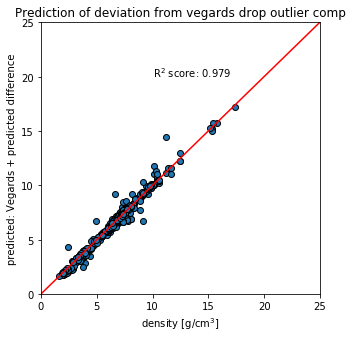

In [117]:
notTroubleDF['vPlusDiff'] = notTroubleDF['density_vegards'] + notTroubleDF['diff_predict']
r2Comp = r2_score(notTroubleDF['density'], notTroubleDF['vPlusDiff'])
print(r2Comp)

plt.figure(figsize=(5,5))
plt.scatter(notTroubleDF['vPlusDiff'], notTroubleDF['density'], edgecolors='k')
plt.plot([0,25], [0,25], 'r-')
plt.xlabel('density [g/cm$^3$]')
plt.ylabel('predicted: Vegards + predicted difference')


plt.text(10,20, 'R$^2$ score: {:.3f}'.format(r2Comp))
plt.xlim([0,25])
plt.ylim([0,25])
plt.title('Prediction of deviation from vegards drop outlier comp')

if saveFigures:
    plt.savefig(os.path.join(os.getcwd(),'results','densityDiffScatter_VegardsPlusDiff.png'))
    print('figure saved')

# Try to predict Vegard's law directly

In [118]:
# Train on difference
vegardFeats = pd.DataFrame()

# take predicted values from each cross validation set to ensure training not performed on own set.  Take 200 training samples
# Probably could have used cross_val_predict
kf = KFold(5)
rep=0
notTroubleDF['vegards_predict'] = np.nan
for train_index, test_index in kf.split(notTroubleDF['comp']):
    print('Split #{}, training on {}'.format(rep, len(train_index)))
    density_model.fit(X_notTrouble[train_index,:], notTroubleDF['density_vegards'][train_index])
    
    y_pred = density_model.predict(X_notTrouble[test_index,:])
    notTroubleDF['vegards_predict'][test_index] = y_pred
    
    
    featureImp = pd.DataFrame(density_model.steps[1][1].feature_importances_,
                          index=dens_featurizer.feature_labels(),
                          columns=['importance']).sort_values('importance',ascending=False)
    print(featureImp.head())
    
    vegardFeats = vegardFeats.append(featureImp)

    rep+=1

Split #0, training on 555
                        importance
mean NValence             0.069204
mode Number               0.063939
mean Electronegativity    0.044993
mean NdValence            0.043229
mean Column               0.037068
Split #1, training on 555
                        importance
mode AtomicWeight         0.082678
mode Number               0.072935
mean NValence             0.051796
mean Number               0.044637
mean Electronegativity    0.039969
Split #2, training on 555
                         importance
mode AtomicWeight          0.079128
mode Number                0.058020
avg d valence electrons    0.055308
mode NValence              0.052046
mean NValence              0.042370
Split #3, training on 555
                         importance
mean NValence              0.076489
mean Number                0.067652
mode AtomicWeight          0.058352
avg d valence electrons    0.056415
mode NValence              0.050389
Split #4, training on 556
                  

In [119]:
# Sort and compile importances
vegardFeats['totalImp'] = vegardFeats.groupby(level=0)['importance'].transform('sum')
vegardFeats = vegardFeats.drop_duplicates(subset=['totalImp']).sort_values('totalImp',ascending=False)
print('top features over 5 training splits')
vegardFeats.head()
vegardFeats.to_csv(os.path.join(os.getcwd(),'results','avgTopFeats_densityVegards.csv'))

top features over 5 training splits


0.9494800505646892
figure saved


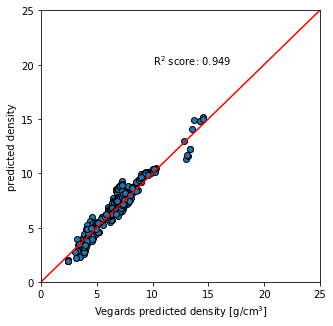

In [120]:
r2Veg = r2_score(notTroubleDF['density_vegards'], notTroubleDF['vegards_predict'])
print(r2Veg)

plt.figure(figsize=(5,5))
plt.scatter(notTroubleDF['vegards_predict'], notTroubleDF['density_predict'], edgecolors='k')
plt.plot([0,25], [0,25], 'r-')
plt.xlabel('Vegards predicted density [g/cm$^3$]')
plt.ylabel('predicted density')


plt.text(10,20, 'R$^2$ score: {:.3f}'.format(r2Veg))
plt.xlim([0,25])
plt.ylim([0,25])
#plt.title('')

if saveFigures:
    plt.savefig(os.path.join(os.getcwd(),'results','densityScatter_VegardsPredict.png'))
    print('figure saved')

# Restrict to 12 Features with varying importance
Omitting outliers
Compare to best model: Vegards+Difference predictions
ref: Jae/Nils attempts

In [121]:
varyFeatData = notTroubleDF[['comp', 'density', 'density_vegards', 'vegards_diff','vPlusDiff']]
varyFeatData.head()

,comp,density,density_vegards,vegards_diff,vPlusDiff
0,"(Ce, Al)",3.462,3.1070,0.355,3.418790
1,"(Al, Fe, B)",3.539,3.6620,-0.123,4.377142
2,"(Zr, Al, Ni)",3.384,3.5105,-0.1265,3.582263
3,"(Zr, Al, Ni)",3.517,3.6965,-0.1795,3.765707
4,"(Hf, Al, Ni)",2.835,3.8505,-1.0155,3.967953


In [122]:
#Train density_model on all data several times, get consistently performing features
featListSorted = pd.DataFrame()

kf = KFold(5)
rep=0
for train_index, test_index in kf.split(notTroubleDF['comp']):
    print('Split #{}, training on {}'.format(rep, len(train_index)))
    density_model.fit(X_notTrouble[train_index,:], notTroubleDF['density'][train_index])
   
    topFeats = pd.DataFrame(density_model.steps[1][1].feature_importances_,
                          index=dens_featurizer.feature_labels(),
                          columns=['importance']).sort_values('importance', ascending=False)
    
    featListSorted = featListSorted.append(topFeats)
    rep += 1
    
    
featListSorted['totalImp'] = featListSorted.groupby(level=0)['importance'].transform('sum')
featListSorted = featListSorted.drop_duplicates(subset=['totalImp']).sort_values('totalImp',ascending=False)
print('top features over 5 training splits:')
featListSorted.head()

Split #0, training on 555
Split #1, training on 555
Split #2, training on 555
Split #3, training on 555
Split #4, training on 556
top features over 5 training splits:


,importance,totalImp
mode AtomicWeight,0.042562,0.334090
mode Number,0.030902,0.297319
mean NValence,0.057231,0.288785
mode NValence,0.068930,0.256911
mean Number,0.023545,0.173221


In [123]:
featList = pd.DataFrame(density_model.steps[1][1].feature_importances_,
                          index=dens_featurizer.feature_labels(),
                          columns=['importance'])
featList.reset_index(inplace=True)

In [124]:
#diffFeatTop
#densFeatTop
# Gather default ordering of features
#featList = pd.DataFrame(density_model.steps[1][1].feature_importances_,
#                          index=dens_featurizer.feature_labels(),
#                          columns=['importance'])
#featList.reset_index(inplace=True)

scoreDict = {}
colList = []

for n in range(0, len(featList)-20, 5):
    # Grab n to n+12th most important features
    featIndex = featList[ [x in diffFeatTop.iloc[n:n+20].index for x in featList['index']] ].index.values

    X_temp = X_notTrouble[:, featIndex]

    # Begin training with 5-fold CV
    kf = KFold(5)
    rep=0
    
    scoreDict[n] = []
    print('--------------------------------------------------------')
    for train_index, test_index in kf.split(varyFeatData['comp']):
        # String for column name
        colStr = 'n{}Part{}_predict'.format(n, rep)
        colList.append(colStr)
        
        print('Split #{}, training on {}: {}'.format(rep, len(train_index), colStr))
        
        varyFeatData[colStr] = np.nan    
        
        density_model.fit(X_temp[train_index,:], varyFeatData['density'][train_index])

        y_pred = density_model.predict(X_temp[test_index,:])
        varyFeatData[colStr][test_index] = y_pred

        #print(train_index, test_index)
        rep+=1
   

--------------------------------------------------------
Split #0, training on 555: n0Part0_predict
Split #1, training on 555: n0Part1_predict
Split #2, training on 555: n0Part2_predict
Split #3, training on 555: n0Part3_predict
Split #4, training on 556: n0Part4_predict
--------------------------------------------------------
Split #0, training on 555: n5Part0_predict
Split #1, training on 555: n5Part1_predict
Split #2, training on 555: n5Part2_predict
Split #3, training on 555: n5Part3_predict
Split #4, training on 556: n5Part4_predict
--------------------------------------------------------
Split #0, training on 555: n10Part0_predict
Split #1, training on 555: n10Part1_predict
Split #2, training on 555: n10Part2_predict
Split #3, training on 555: n10Part3_predict
Split #4, training on 556: n10Part4_predict
--------------------------------------------------------
Split #0, training on 555: n15Part0_predict
Split #1, training on 555: n15Part1_predict
Split #2, training on 555: n15Part

In [125]:
varyFeatData.head()

,comp,density,density_vegards,vegards_diff,vPlusDiff,n0Part0_predict,n0Part1_predict,n0Part2_predict,n0Part3_predict,n0Part4_predict,...,n125Part0_predict,n125Part1_predict,n125Part2_predict,n125Part3_predict,n125Part4_predict,n130Part0_predict,n130Part1_predict,n130Part2_predict,n130Part3_predict,n130Part4_predict
0,"(Ce, Al)",3.462,3.1070,0.355,3.418790,3.923103,NaN,NaN,NaN,NaN,...,4.401029,NaN,NaN,NaN,NaN,4.207330,NaN,NaN,NaN,NaN
1,"(Al, Fe, B)",3.539,3.6620,-0.123,4.377142,4.650380,NaN,NaN,NaN,NaN,...,4.274711,NaN,NaN,NaN,NaN,4.145395,NaN,NaN,NaN,NaN
2,"(Zr, Al, Ni)",3.384,3.5105,-0.1265,3.582263,3.984405,NaN,NaN,NaN,NaN,...,3.773131,NaN,NaN,NaN,NaN,4.145395,NaN,NaN,NaN,NaN
3,"(Zr, Al, Ni)",3.517,3.6965,-0.1795,3.765707,4.017775,NaN,NaN,NaN,NaN,...,3.773131,NaN,NaN,NaN,NaN,4.145395,NaN,NaN,NaN,NaN
4,"(Hf, Al, Ni)",2.835,3.8505,-1.0155,3.967953,3.968335,NaN,NaN,NaN,NaN,...,3.773131,NaN,NaN,NaN,NaN,4.145395,NaN,NaN,NaN,NaN


In [127]:
for name in colList:
    num = int(re.search('n(\d*)Part*', name)[1])
    currSplit = varyFeatData[ ~varyFeatData[name].apply(np.isnan) ]
    scoreDict[num].append( r2_score(currSplit['density'], currSplit[name]))
    
#print('avg: {}, std: {}'.format(np.mean(scores),np.std(scores)))

In [128]:
ns = []
avgs = []
meds = []
stds = []
mins = []
for key, item in scoreDict.items():
    ns.append(key)
    avgs.append(np.mean(item))
    meds.append(np.median(item))
    stds.append(np.std(item))
    mins.append(np.min(item))

In [129]:
ns = np.array(ns)
avgs = np.array(avgs)
meds = np.array(meds)
stds = np.array(stds)
mins = np.array(mins)

figure saved


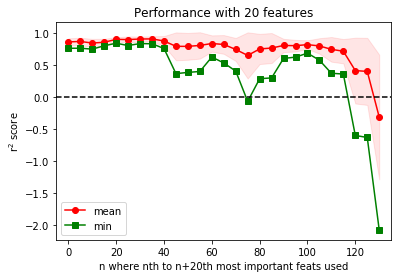

In [131]:
plt.figure()

plt.title('Performance with 20 features')
plt.xlabel('n where nth to n+20th most important feats used')
plt.ylabel('r$^2$ score')

plt.fill_between(ns, avgs - stds,
                 avgs + stds, alpha=0.1,
                 color="r")
plt.plot(ns, avgs, 'o-', color="r", label='mean')
plt.plot(ns, mins, 's-', color='g', label='min')
plt.plot([-5,ns[-1]+5], [0, 0], '--', color='k')
plt.legend(loc='lower left')

plt.xlim([-5,ns[-1]+5])

if saveFigures:
    plt.savefig(os.path.join(os.getcwd(),'results','featElim_20_noOut.png'))
    print('figure saved')

In [236]:
# Sum importances
featListSorted['cumSum_totalImp'] = featListSorted['totalImp'].cumsum()/5

figure saved


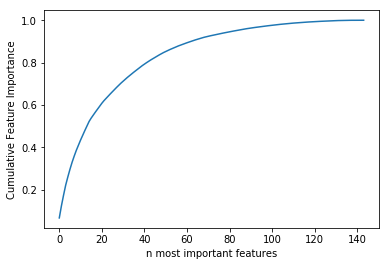

In [239]:
plt.figure()

plt.plot(range(len(featListSorted)), featListSorted['cumSum_totalImp'])
plt.ylabel('Cumulative Feature Importance')
plt.xlabel('n most important features')

if saveFigures:
    plt.savefig(os.path.join(os.getcwd(),'results','cumSum_FeatImp.png'))
    print('figure saved')